In [35]:
import seaborn as sns
sns.set_style('whitegrid')

In [1]:
"""This Program Uses Stock Data and Regression Methods to Verify CAPM Model"""

'This Program Uses Stock Data and Regression Methods to Verify CAPM Model'

In [2]:
import pandas as pd
import numpy as np


def data_analysis():
    stock_symbols = {
        'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DWDP', 'XOM',
        'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
        'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'WBA', 'DIS'
    }  # Dow Jones 30 stocks
    data = pd.read_csv('Clean_Data_Out.csv')

    data = data.loc[data['Name'].isin(stock_symbols)]

    # Convert Date column from string to datetime
    data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')

    # Add column for daily returns
    data['daily_return'] = np.log(data['close'] / data['open'])

    treasury_data = pd.read_csv('Treasury Bill Yield Curve.csv')

    # T-bill not available for certain dates (dates are not consecutive).
    # Use linear interpolation to proxy for the t-bill rate for that date.
    for i, row in treasury_data.iterrows():
        if row['10 Yr T bill'] == 'NA':
            # Assuming that isnull does not occur when i == 0 and when i == len(treasury_data) - 1
            treasury_data['10 Yr T bill'][
                i] = 0.5 * (treasury_data['10 Yr T bill'][i - 1] +
                            treasury_data['10 Yr T bill'][i + 1])

    # Convert Date column from string to datetime
    treasury_data['Date'] = pd.to_datetime(
        treasury_data['Date'], format='%m/%d/%Y')

    # Reformat 10 Yr T bill return into decimals (original data was in %)
    treasury_data['10 Yr T bill returns'] = treasury_data['10 Yr T bill'] / 100

    # Calculate SP 500 returns
    treasury_data[
        'SP 500 Returns'] = treasury_data['SP 500 '] / treasury_data['SP 500 '].shift(
        ) - 1

    # Perform a left join
    data = pd.merge(
        data, treasury_data, left_on='date', right_on='Date', how='left')

    # Calculate Beta for individual stock.

    data['CAPM return'] = 0
    for stock_symbol in stock_symbols:
        stock_data = data.loc[data['Name'] == stock_symbol]

        # Covariance between individual stock vs. market (SP 500):
        cov = stock_data['daily_return'].rolling(
            63, min_periods=63).cov(
                other=stock_data['SP 500 Returns'], pairwise=False)

        # Variance of market
        var = stock_data['SP 500 Returns'].rolling(63, min_periods=63).var()

        # Beta = Covariance [Return of Asset & Return of Market] / Variance [Return of Market]
        beta = cov / var

        # CAPM Return = Rf + Beta * (Mkt Return - Rf)
        # Rf = T bill rate
        # Mkt Return = SP 500
        data.loc[data['Name'] == stock_symbol,
                 'CAPM return'] = stock_data['10 Yr T bill returns'] + beta * (
                     stock_data['SP 500 Returns'] -
                     stock_data['10 Yr T bill returns'])

    # Finally, calculate the difference between actual daily return vs. CAPM predicted return
    data['residuals'] = data['CAPM return'] - data['daily_return']
    return data


data = data_analysis()
data.to_csv('Cleaned_Data_Analyzed.csv')

In [3]:
data.describe()

,open,high,low,close,volume,daily_return,10 Yr T bill,SP 500,10 Yr T bill returns,SP 500 Returns,CAPM return,residuals
count,36650.000000,36650.000000,36650.000000,36650.000000,3.665000e+04,36650.000000,36358.000000,36620.000000,36358.000000,36620.000000,32705.000000,32705.000000
mean,90.166095,90.821149,89.518600,90.194471,1.213429e+07,0.000322,2.254055,2063.999644,0.022541,0.000486,0.009882,0.009611
std,45.770272,46.100049,45.455599,45.791180,1.553995e+07,0.009704,0.350964,285.055154,0.003510,0.007595,0.007246,0.010101
min,20.200000,20.490000,19.980000,20.230000,3.053580e+05,-0.104010,1.370000,1487.850000,0.013700,-0.040979,-0.051616,-0.068918
25%,55.000000,55.462500,54.522500,55.002500,4.033024e+06,-0.004905,2.000000,1877.170000,0.020000,-0.002859,0.005766,0.003643
50%,83.820000,84.390000,83.210000,83.855000,7.068024e+06,0.000378,2.280000,2061.020000,0.022800,0.000538,0.010643,0.009897
75%,114.237500,115.030000,113.410000,114.260000,1.404172e+07,0.005653,2.520000,2185.790000,0.025200,0.004607,0.014863,0.015911
max,360.500000,361.450000,352.040000,356.940000,6.182376e+08,0.083386,3.040000,2872.870000,0.030400,0.039034,0.032779,0.115211


In [4]:
dji_stock = {
    'MMM', 'AXP', 'AAPL', 'BA', 'CAT', 'CVX', 'CSCO', 'KO', 'DWDP', 'XOM',
    'GS', 'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'MCD', 'MRK', 'MSFT', 'NKE',
    'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'VZ', 'V', 'WMT', 'WBA', 'DIS'
}

In [8]:
data = pd.read_csv('Clean_Data_Out.csv')
data = data.loc[data['Name'].isin(dji_stock)]
data['daily_return'] = np.log(data['close'] / data['open'])

In [12]:
rets = data.set_index(['date', 'Name']).daily_return.unstack()

In [60]:
mus = rets.mean()
covs = rets.cov()

In [29]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd

In [48]:
# Turn off progress printing
solvers.options['show_progress'] = False

In [111]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.randn(n)
    return k / sum(k)

In [120]:
def random_portfolio(mus, covs):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(mus)
    w = np.asmatrix(rand_weights(mus.shape[0]))
    C = np.asmatrix(covs)

    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)

    # This recursion reduces outliers to keep plots pretty
    if sigma > 0.01:
        return random_portfolio(mus, covs)
    return mu, sigma

In [124]:
n_portfolios = 500
means, stds = np.column_stack([random_portfolio(mus, covs) for _ in range(n_portfolios)])

Text(0.5,1,'Mean and standard deviation of returns of randomly generated portfolios')

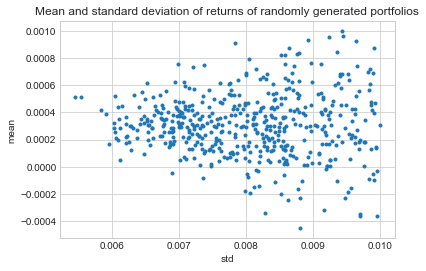

In [125]:
plt.plot(stds, means, 'o', markersize=3)
plt.xlabel('std')
plt.ylabel('mean')
plt.title(
    'Mean and standard deviation of returns of randomly generated portfolios')

In [94]:
def optimal_portfolio(means, covs):
    n = means.shape[0]

    N = 1000
    mus = [10**(5.0 * t / N -1) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.array(covs))
    pbar = opt.matrix(np.array(means))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))  # negative n x n identity matrix
    h = opt.matrix(0.0, (n, 1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu * S, -pbar, G, h, A, b)['x'] for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S * x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

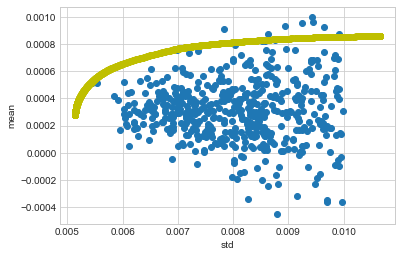

In [126]:
weights, returns, risks = optimal_portfolio(mus, covs)

plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')